In [588]:
import pandas as pd
import onc
import os
import json
from dotenv import load_dotenv
from typing import List, Tuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import reduce


load_dotenv()
token = os.getenv("ONC_TOKEN")

# Create ONC client using the SDK
my_onc = onc.ONC(token)


In [589]:
"""
Fetches scalar data using the ONC Python SDK for a given location, device category, property (sensorCategoryCode) and time window.
Returns a dataframe with timestamps, values and flags.
"""

def get_property(start: str, end: str, locationCode: str, deviceCategoryCode: str, sensorCategoryCode: str) -> pd.DataFrame:

    params = {
        "locationCode": locationCode,
        "deviceCategoryCode": deviceCategoryCode,
        "sensorCategoryCodes": sensorCategoryCode,
        "dateFrom": start,
        "dateTo" : end
    }

    # JSON response from ONC
    result = my_onc.getScalardata(params)

    # error handle if there is no data returned
    if not result or "sensorData" not in result or result["sensorData"] is None or len(result["sensorData"]) == 0:
        print(f"No data returned for devices in {deviceCategoryCode} at {locationCode} between {start} and {end}.")
        return
        
    else:
        # extract the relevant sensors
        # order: depth, temperature
        #sensor = result["sensorData"][0]

        dfs = []

        for sensor in result["sensorData"]:
            # extract each sensors data fields
            prop = sensor["sensorCategoryCode"]
            times = sensor["data"]["sampleTimes"]
            values = sensor["data"]["values"]
            unit = sensor["unitOfMeasure"]

            # populate dataframe (Pandas)
            df = pd.DataFrame({
                # syntax: "label": variable
                "timestamp": pd.to_datetime(times), # convert strings to datetime objects
                prop: values,
                "uom": unit
            })
            dfs.append(df)
        
    df_merged = reduce(lambda left, right: pd.merge(left, right, on="timestamp", how="outer"), dfs)
    df_merged.sort_values("timestamp", inplace=True)
    #print(df_merged)
    return df_merged

In [590]:
def detect_cast_intervals(df: pd.DataFrame, gap_threshold_minutes: int = 10) -> List[Tuple[pd.Timedelta, pd.Timedelta]]:
    """
    Detects individual CTD cast intervals based on time gaps in the data.

    Parameters:
        df (pd.DataFrame): DataFrame with a 'timestamp' column (datetime format).
        gap_threshold_minutes (int): Time gap threshold to detect breaks between casts.

    Returns:
        List[Tuple[pd.Timedelta, pd.Timedelta]]: List of (dateFrom, dateTo) pairs in ISO 8601 UTC format.
    """
    if df.empty or "timestamp" not in df.columns:
        return []

    # Sort and reset index
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Calculate time gaps between consecutive timestamps
    gaps = df["timestamp"].diff().fillna(pd.Timedelta(seconds=0))
    new_cast_starts = df.index[gaps > pd.Timedelta(minutes=gap_threshold_minutes)].tolist()

    # Start of first cast is always 0
    cast_starts = [0] + new_cast_starts
    cast_ends = new_cast_starts + [len(df)]

    # Format intervals as ISO 8601 with milliseconds and Z (UTC)
    intervals = []
    for start_idx, end_idx in zip(cast_starts, cast_ends):
        start = df["timestamp"].iloc[start_idx].strftime("%Y-%m-%dT%H:%M:%S.000Z")
        end = df["timestamp"].iloc[end_idx - 1].strftime("%Y-%m-%dT%H:%M:%S.000Z")
        intervals.append((start,end))

    return intervals


In [591]:
def detect_deep_intervals(df, depth_threshold, gap_threshold_seconds=60):
    """
    Detects continuous time intervals where depth exceeds a threshold.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'timestamp' and 'depth' columns.
        depth_threshold (float): Minimum depth to include.
        gap_threshold_seconds (int): Max allowed time gap between points within an interval.
    
    Returns:
        List[Tuple[str, str]]: List of (start, end) timestamp strings in ISO 8601 UTC format.
    """
    df_deep = df[df["depth"] > depth_threshold].copy()

    if df_deep.empty:
        return []

    df_deep = df_deep.sort_values("timestamp").reset_index(drop=True)
    df_deep["delta"] = df_deep["timestamp"].diff().dt.total_seconds()

    intervals = []
    start_time = df_deep.loc[0, "timestamp"]

    for i in range(1, len(df_deep)):
        if df_deep.loc[i, "delta"] > gap_threshold_seconds:
            end_time = df_deep.loc[i - 1, "timestamp"]
            intervals.append((
                start_time.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
                end_time.strftime("%Y-%m-%dT%H:%M:%S.000Z")
            ))
            start_time = df_deep.loc[i, "timestamp"]

    # Add final interval
    intervals.append((
        start_time.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
        df_deep.iloc[-1]["timestamp"].strftime("%Y-%m-%dT%H:%M:%S.000Z")
    ))

    return intervals


In [592]:
def plot_cast(start: pd.Timedelta, end: pd.Timedelta, locationCode: str, deviceCategoryCode: str,
                  sensorCategoryCode: str, df: pd.DataFrame, depth_theshold: int) -> None:
    """
    Plots a sensor property time-series with optional cast interval markers.

    Parameters:
        start (pd.Timedelta): Start time in ISO 8601 format.
        end (pd.Timedelta): End time in ISO 8601 format.
        locationCode (str): ONC location code.
        deviceCategoryCode (str): ONC device category.
        sensorCategoryCode (str): Sensor property (e.g., "depth").
        df (pd.DataFrame): DataFrame containing 'timestamp' and property column.
    """

    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    
    df_int = df[
        (df["timestamp"] >= start_dt) &
        (df["timestamp"] <= end_dt) &
        (df["depth"] >= depth_theshold)
    ]

    if df_int.empty:
        print(f"Skipping empty cast interval: {start} to {end}")
        return

    df_int.plot(
        x="temperature",
        y="depth",
        xlabel="Temperature (°C)",
        ylabel="Depth (m)",
        title=f"CTD Cast at {locationCode}\n{start_dt.strftime('%H:%M:%S')} to {end_dt.strftime('%H:%M:%S')} UTC"
    )


In [593]:
def plot_mount(start: pd.Timedelta, end: pd.Timedelta, locationCode: str, deviceCategoryCode: str,
                  sensorCategoryCode: str, df: pd.DataFrame) -> None:
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)

    df_int = df[(df["timestamp"] >= start) & (df["timestamp"] <= end)] # filter the df to get the relevant cast interval
    
    df_int.plot(x = "timestamp", 
                y = "temperature", 
                xlabel = "Time", 
                ylabel = "Temperature (C)", 
                title = f"CTD Mount at {locationCode}\n {start_dt.strftime('%H:%M:%S')} to {end_dt.strftime('%H:%M:%S')} UTC" # plot and label
    )

### CTD Casts vs Mount Temperature Data at Fogler Pinnacle Jul-11-2023

#### Notes:
#### - I estimated Pinnacle depth as 23m and have filtered cast data for when the cast is at least 20m deep
#### - Other than displaying data from the exact time frame of the cast, and filtering for the sub section where the cast is at least 20m deep, I have applied to no real processing
#### - I have not yet put the mount and cast data on the same plot, but that will be a goal for tomorrow

#### Possible Issues:
#### - Closeness of depth needed to compare casts/mounts and extremely small time series 

Cast intervals:
Start: 2023-07-11T17:12:51.000Z, End: 2023-07-11T17:14:20.000Z
Start: 2023-07-11T20:13:27.000Z, End: 2023-07-11T20:15:39.000Z

Deep section of cast intervals:
Start: 2023-07-11T17:13:58.000Z, End: 2023-07-11T17:14:20.000Z
Start: 2023-07-11T20:15:03.000Z, End: 2023-07-11T20:15:39.000Z


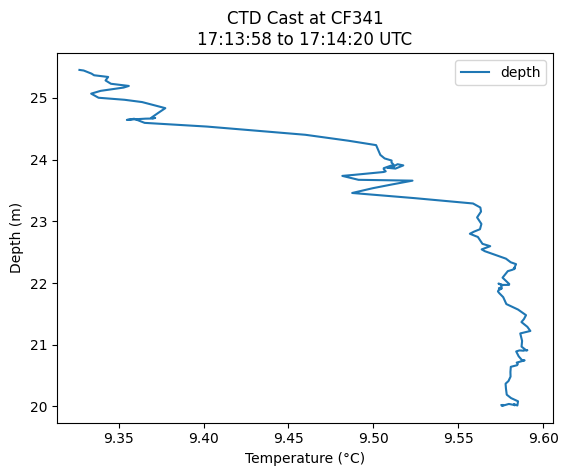

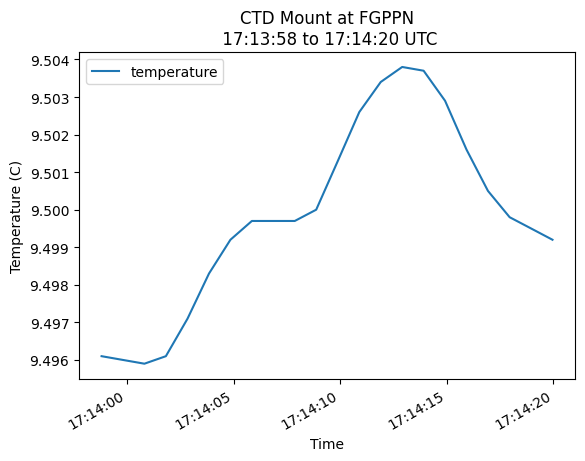

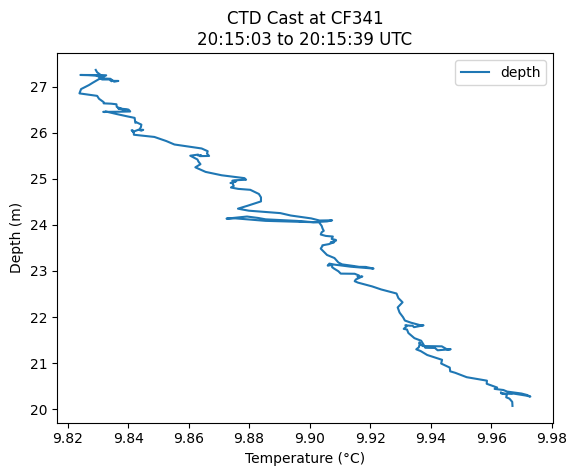

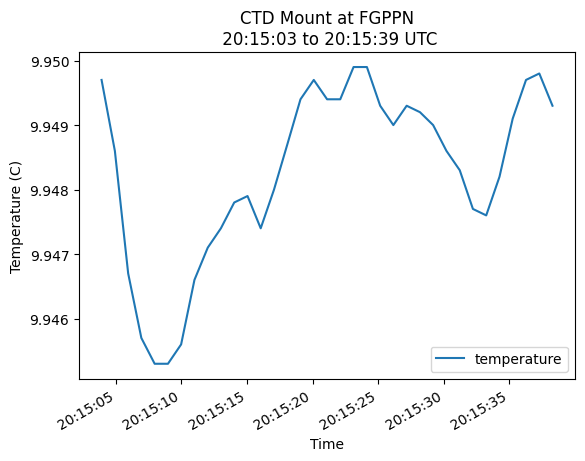

In [594]:
dateFrom = "2023-07-11T17:00:00.000Z"
dateTo = "2023-07-11T22:30:00.000Z"

cast_df = get_property(dateFrom, dateTo, "CF341", "CTD", "depth,temperature") # populate dataframe of entire day
mount_df = get_property(dateFrom, dateTo, "FGPPN", "CTD", "temperature")

cast_ints = detect_cast_intervals(cast_df, 10) # isolate time intervals for each cast
print("Cast intervals:")
for cast_start, cast_end in cast_ints:
   print(f"Start: {cast_start}, End: {cast_end}") 

print()

deep_ints = detect_deep_intervals(cast_df, 20, 60) # isolate time intervals for each cast
print("Deep section of cast intervals:")
for cast_start, cast_end in deep_ints:
   print(f"Start: {cast_start}, End: {cast_end}") 
   plot_cast(cast_start, cast_end, "CF341", "CTD", "depth", cast_df, 20) # plot depth and temperature profile for each cast
   plot_mount(cast_start, cast_end, "FGPPN", "CTD", "depth", mount_df)
   
